In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   ##绘图库
import seaborn as sns ##图片风格扩展
from datetime import timedelta  #时间
from sklearn.preprocessing import LabelEncoder  ##label编码
from matplotlib import font_manager  ##解决中文字符显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为新宋体。
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时'-'显示为方块的问题。
from matplotlib import colors

from sklearn.preprocessing import MinMaxScaler


from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split   ## 划分
from sklearn.linear_model import LinearRegression  ##多元线性回归
from sklearn.metrics import mean_squared_error  ##方差
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from sklearn.metrics import r2_score


import torch
## 代替keras库
from torch import nn
from sklearn.preprocessing import MinMaxScaler

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # 使用 CPU
    print("Using CPU")


Using GPU: NVIDIA GeForce MX450


数据处理，清洗天气数据，对列名重命名，求每日均值

In [3]:
# 加载 csv文件
weather_data = pd.read_csv('weatherdata.csv')

# 将时间列转化为日期时间格式
weather_data['当地时间 北京'] = pd.to_datetime(weather_data['当地时间 北京'], format='%d.%m.%Y %H:%M')  # 处理中文版本csv文件 

# 遍历数据集中的每一个列
for col in weather_data.columns:
    # 如果数据类型是非数值型并且列名不是'当地时间 北京'
    if pd.api.types.is_string_dtype(weather_data[col]) and col != '当地时间 北京':  # 对中文版csv文件操作
        # 使用factorize对非数值型的列进行编码
        weather_data[col] = pd.factorize(weather_data[col])[0]

# 下面的步骤只会对数值类型的列进行操作
numeric_columns = weather_data.columns[weather_data.dtypes != 'object']

# 使用每列的平均值填充对应列的缺失值
weather_data[numeric_columns] = weather_data[numeric_columns].fillna(weather_data[numeric_columns].mean())
# 删除含有 NaN 的列
weather_data = weather_data.dropna(axis=1)

# 定义新的列名
column_dict = {'当地时间 北京':'日期','T': '气温', 'Po': '气压', 'P': '平均海平面大气压', 'Pa': '气压趋势', 'U': '湿度', 'DD': '风向', 'Ff': '平均风速', 'ff3': '最大阵风', 'WW': '天气情况', 'Tn': '最低气温', 'Tx': '最高气温', 'Td': '露点温度', 'tR': '降水时间'}

# 更改列名
weather_data = weather_data.rename(columns=column_dict)

# 从'日期'列中提取日期
weather_data['日期'] = pd.to_datetime(weather_data['日期']).dt.date

# 计算每日平均值
daily_avg_data = weather_data.groupby('日期').mean().reset_index()

# 检查结果
daily_avg_data

,日期,气温,气压,平均海平面大气压,气压趋势,湿度,风向,平均风速,最大阵风,天气情况,最低气温,最高气温,露点温度,降水时间
0,2013-12-02,3.1625,759.7125,764.4625,-0.0125,45.875,7.375,1.375,7.176996,5.500,6.896037,18.301323,-8.5875,10.716845
1,2013-12-03,5.4875,761.7250,766.4250,0.1000,39.000,8.000,1.625,7.176996,4.750,7.208537,18.313823,-8.9000,10.716845
2,2013-12-04,5.2500,760.3000,764.9875,-0.1375,45.375,9.375,1.250,7.176996,1.750,7.133537,18.713823,-6.6750,10.716845
3,2013-12-05,6.1500,763.2750,767.9750,0.2500,30.000,6.875,2.250,7.176996,3.875,7.758537,18.551323,-10.9125,10.716845
4,2013-12-06,2.9250,760.3250,765.0750,-0.2750,52.750,4.875,1.250,7.176996,1.000,7.121037,18.238823,-6.3500,10.716845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,2023-12-26,-2.0500,770.6375,773.9375,0.9250,54.125,8.250,1.500,7.147125,0.500,-9.475000,2.587500,-10.8625,12.000000
3677,2023-12-27,-3.8875,771.5375,774.8500,-0.5375,67.750,7.250,1.125,4.250000,0.000,-8.900000,5.348403,-9.4500,12.000000
3678,2023-12-28,-3.0125,769.1375,772.4375,-0.0375,69.875,6.625,1.000,3.750000,0.375,-9.100000,3.750000,-8.2875,12.000000
3679,2023-12-29,-2.8000,765.1125,768.4000,-0.9375,78.125,5.625,1.125,4.147125,2.000,-6.302352,3.975000,-6.3000,12.000000


合并AQI数据与清洗好的天气数据

In [4]:
# 确保两个 DataFrame 的日期列都是日期格式
aqi_data = pd.read_csv('SeasonAdded.csv')

aqi_data['日期'] = pd.to_datetime(aqi_data['日期'])
daily_avg_data['日期'] = pd.to_datetime(daily_avg_data['日期'])

# 合并两个 DataFrame
merged_data = pd.merge(daily_avg_data, aqi_data, on='日期', how='inner')

merged_data.to_csv('merged_data.csv', index=False)

merged_data

,日期,气温,气压,平均海平面大气压,气压趋势,湿度,风向,平均风速,最大阵风,天气情况,...,降水时间,季节,AQI,质量等级,PM2.5,PM10,NO2,CO,SO2,O3_8h
0,2013-12-02,3.1625,759.7125,764.4625,-0.0125,45.875,7.375,1.375,7.176996,5.500,...,10.716845,冬,142,轻度污染,109,138,88,2.6,61,11
1,2013-12-03,5.4875,761.7250,766.4250,0.1000,39.000,8.000,1.625,7.176996,4.750,...,10.716845,冬,86,良,64,86,54,1.6,38,45
2,2013-12-04,5.2500,760.3000,764.9875,-0.1375,45.375,9.375,1.250,7.176996,1.750,...,10.716845,冬,109,轻度污染,82,101,62,2.0,42,23
3,2013-12-05,6.1500,763.2750,767.9750,0.2500,30.000,6.875,2.250,7.176996,3.875,...,10.716845,冬,56,良,39,56,38,1.2,30,52
4,2013-12-06,2.9250,760.3250,765.0750,-0.2750,52.750,4.875,1.250,7.176996,1.000,...,10.716845,冬,169,中度污染,128,162,78,2.5,48,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,2023-12-26,-2.0500,770.6375,773.9375,0.9250,54.125,8.250,1.500,7.147125,0.500,...,12.000000,冬,55,良,26,46,44,0.7,3,0
3677,2023-12-27,-3.8875,771.5375,774.8500,-0.5375,67.750,7.250,1.125,4.250000,0.000,...,12.000000,冬,64,良,45,71,51,0.8,3,34
3678,2023-12-28,-3.0125,769.1375,772.4375,-0.0375,69.875,6.625,1.000,3.750000,0.375,...,12.000000,冬,129,轻度污染,98,132,69,1.2,3,21
3679,2023-12-29,-2.8000,765.1125,768.4000,-0.9375,78.125,5.625,1.125,4.147125,2.000,...,12.000000,冬,150,轻度污染,115,145,62,1.2,3,45


PM2.5       1.000000
湿度          0.254683
风向          0.181264
平均海平面大气压    0.105069
气压          0.075169
天气情况        0.015611
露点温度       -0.000350
季节         -0.035743
降水时间       -0.048534
最高气温       -0.088200
最低气温       -0.100938
最大阵风       -0.146053
气压趋势       -0.154671
气温         -0.156376
平均风速       -0.288130
Name: PM2.5, dtype: float64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22176\1955616724.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pm25_correlation.values, y=pm25_correlation.index, palette=sns.color_palette("coolwarm", len(pm25_correlation)))


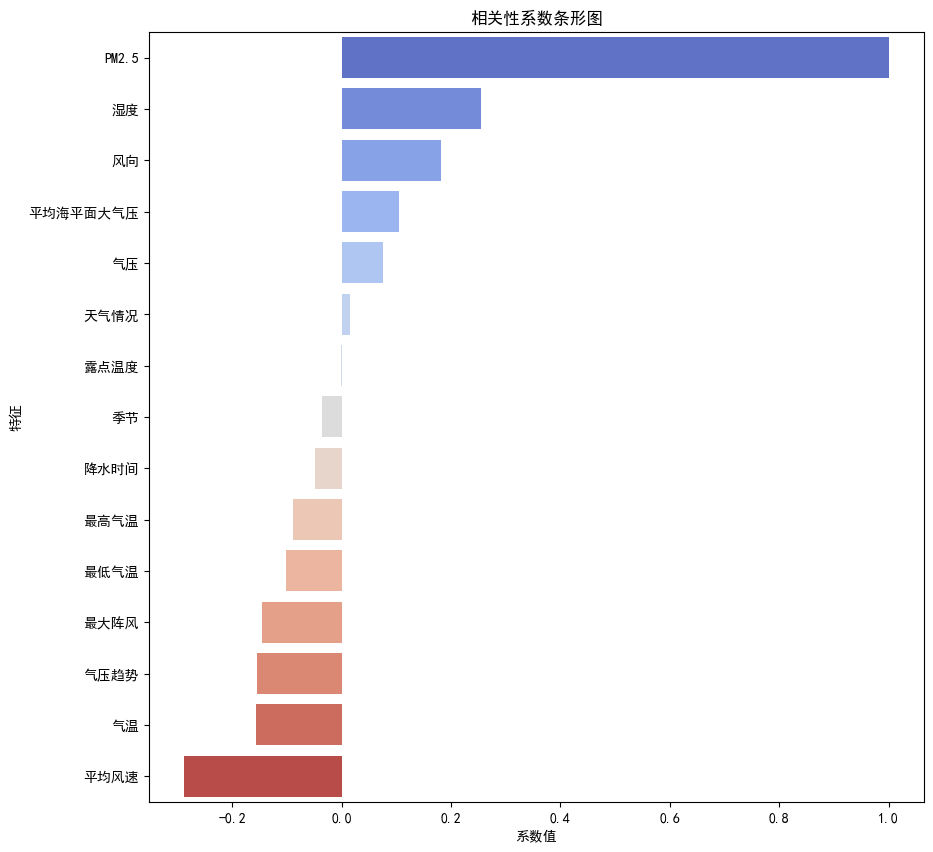

In [5]:
# 定义你需要的列
columns = ['气温', '气压', '平均海平面大气压', '气压趋势', '湿度', '风向', '平均风速', '最大阵风', '天气情况', '最低气温', '最高气温', '露点温度', '降水时间', '季节', 'PM2.5']

# 初始化编码器
encoder = LabelEncoder()

# 对"季节"进行标签编码
merged_data['季节'] = encoder.fit_transform(merged_data['季节'])


# 只选择这些列进行相关性分析
selected_data = merged_data[columns]
correlation = selected_data.corr()

# 找到与'PM2.5'相关的列并按降序排列
pm25_correlation = correlation['PM2.5'].sort_values(ascending=False)

# 打印结果
print(pm25_correlation)


# 创建一个新的图像和设置图像的大小
plt.figure(figsize=(10,10))

# 创建颜色映射，使用颜色渐变。取决对系数值的绝对值创建颜色映射，以表示相关性强度
color_map = colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

# 创建条形图，并用颜色映射来设置每个条的颜色
sns.barplot(x=pm25_correlation.values, y=pm25_correlation.index, palette=sns.color_palette("coolwarm", len(pm25_correlation)))

# 添加标题和标签
plt.title('相关性系数条形图')
plt.xlabel('系数值')
plt.ylabel('特征')

# 显示图像
plt.show()



PM2.5的相关性分析结果：

PM2.5       1.000000
平均风速        0.288130
湿度          0.254683
风向          0.181264
气温          0.156376
气压趋势        0.154671
最大阵风        0.146053
平均海平面大气压    0.105069
最低气温        0.100938
最高气温        0.088200
气压          0.075169
降水时间        0.048534
季节          0.035743
天气情况        0.015611
露点温度        0.000350
Name: PM2.5, dtype: float64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22176\1151200639.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlation_abs.values, y=target_correlation_abs.index, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))


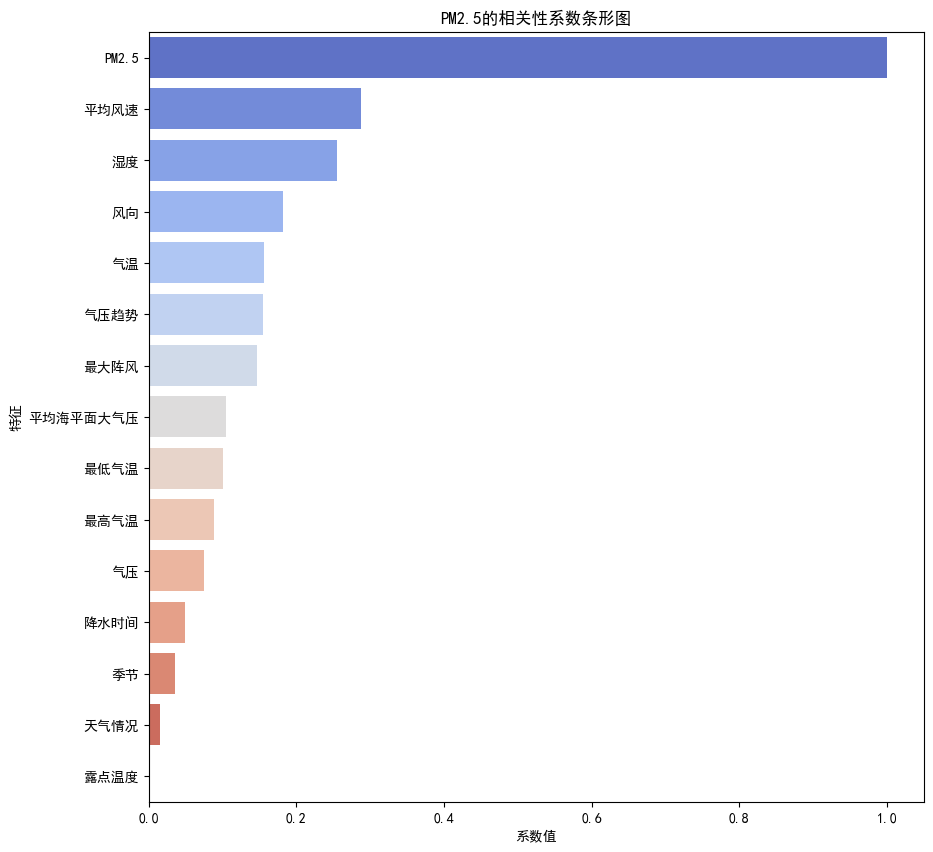


PM10的相关性分析结果：

PM10        1.000000
平均风速        0.183021
气压趋势        0.160883
气温          0.124652
风向          0.116126
最低气温        0.104168
最大阵风        0.087428
露点温度        0.071516
最高气温        0.056745
平均海平面大气压    0.052923
湿度          0.049332
天气情况        0.035941
降水时间        0.033461
气压          0.027194
季节          0.016593
Name: PM10, dtype: float64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22176\1151200639.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlation_abs.values, y=target_correlation_abs.index, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))


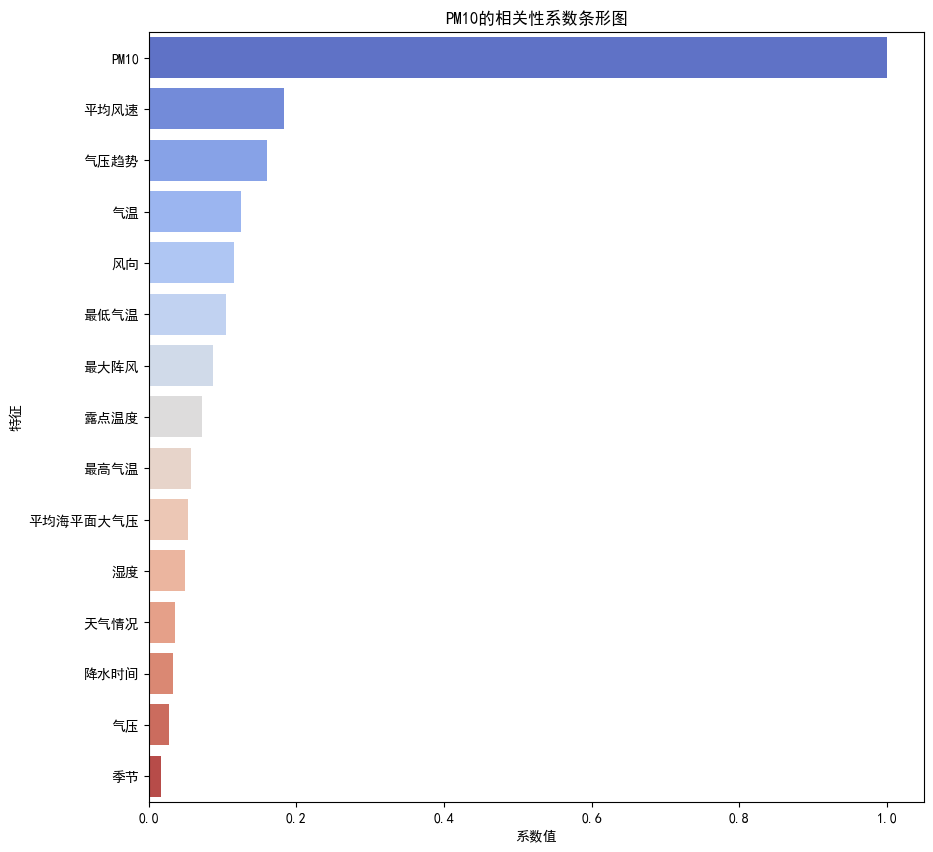

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22176\1151200639.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlation_abs.values, y=target_correlation_abs.index, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))



NO2的相关性分析结果：

NO2         1.000000
气温          0.313375
平均风速        0.305271
平均海平面大气压    0.297696
气压          0.253523
最低气温        0.227686
露点温度        0.223513
最高气温        0.197562
气压趋势        0.167166
风向          0.118285
最大阵风        0.115523
降水时间        0.100654
天气情况        0.099558
湿度          0.011815
季节          0.011596
Name: NO2, dtype: float64


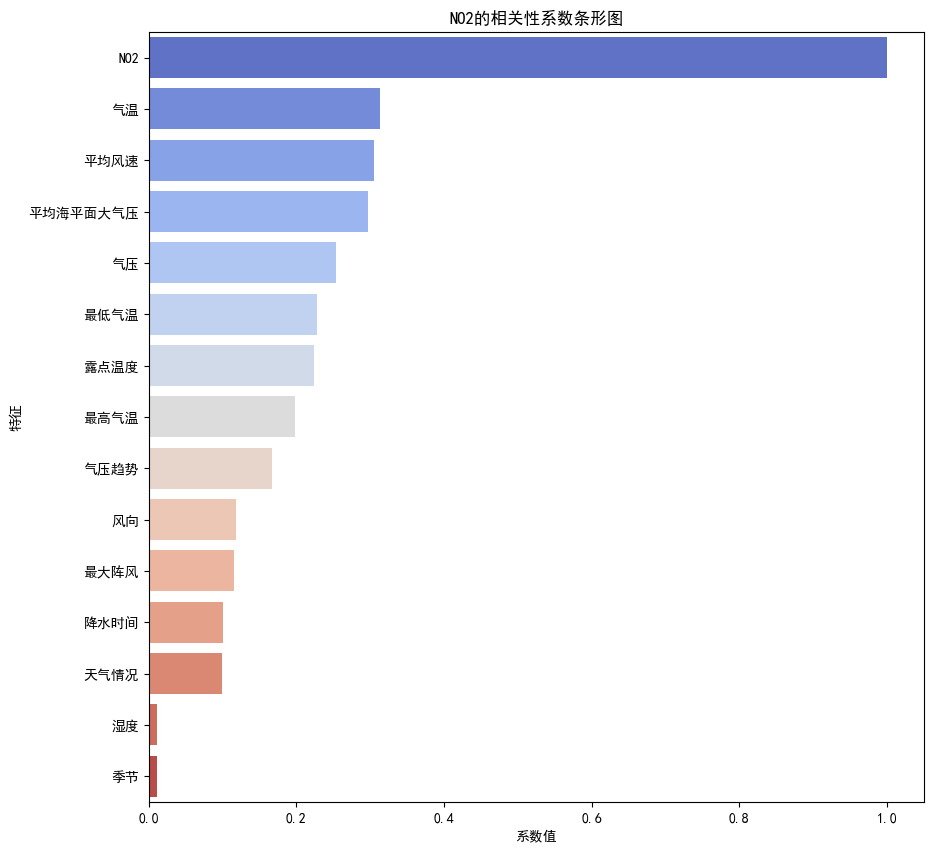


CO的相关性分析结果：

CO          1.000000
平均风速        0.290830
气温          0.247104
湿度          0.232125
风向          0.213774
平均海平面大气压    0.178089
季节          0.156474
气压          0.142584
最大阵风        0.119047
气压趋势        0.102731
天气情况        0.085846
最高气温        0.080422
露点温度        0.077971
降水时间        0.074262
最低气温        0.073583
Name: CO, dtype: float64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22176\1151200639.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlation_abs.values, y=target_correlation_abs.index, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))


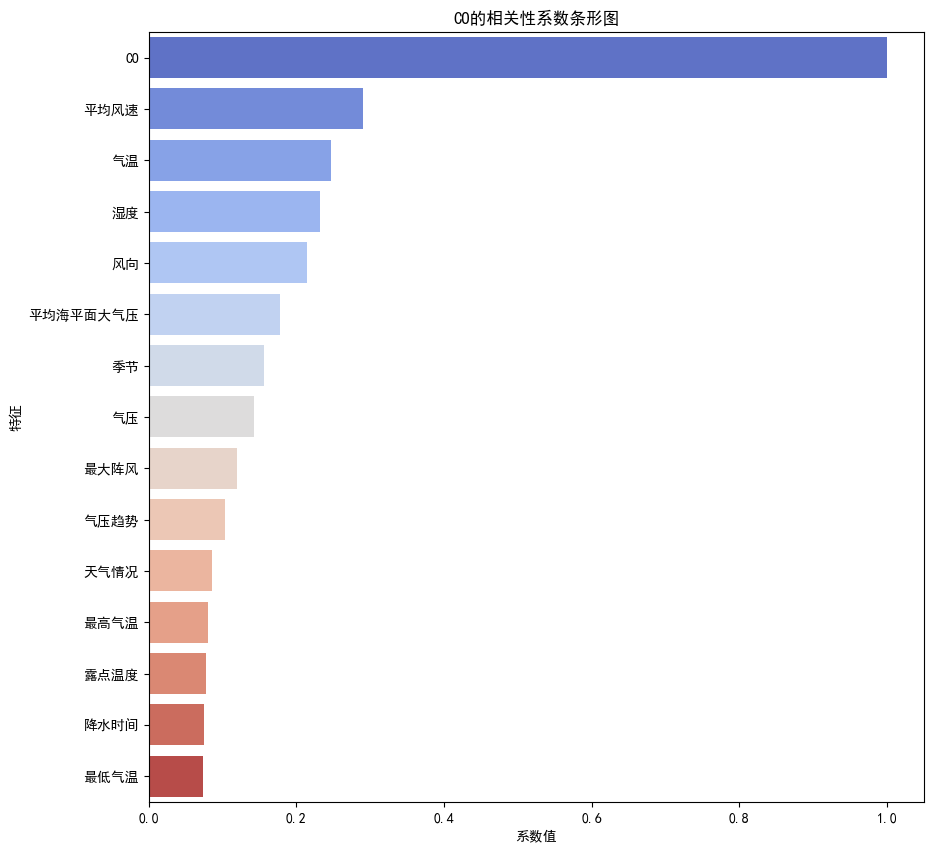


SO2的相关性分析结果：

SO2         1.000000
气温          0.306539
露点温度        0.254694
平均海平面大气压    0.233614
季节          0.227524
气压          0.198480
风向          0.131312
平均风速        0.075902
湿度          0.075378
最低气温        0.073289
最高气温        0.072346
气压趋势        0.066586
降水时间        0.013597
天气情况        0.011971
最大阵风        0.003603
Name: SO2, dtype: float64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22176\1151200639.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlation_abs.values, y=target_correlation_abs.index, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))


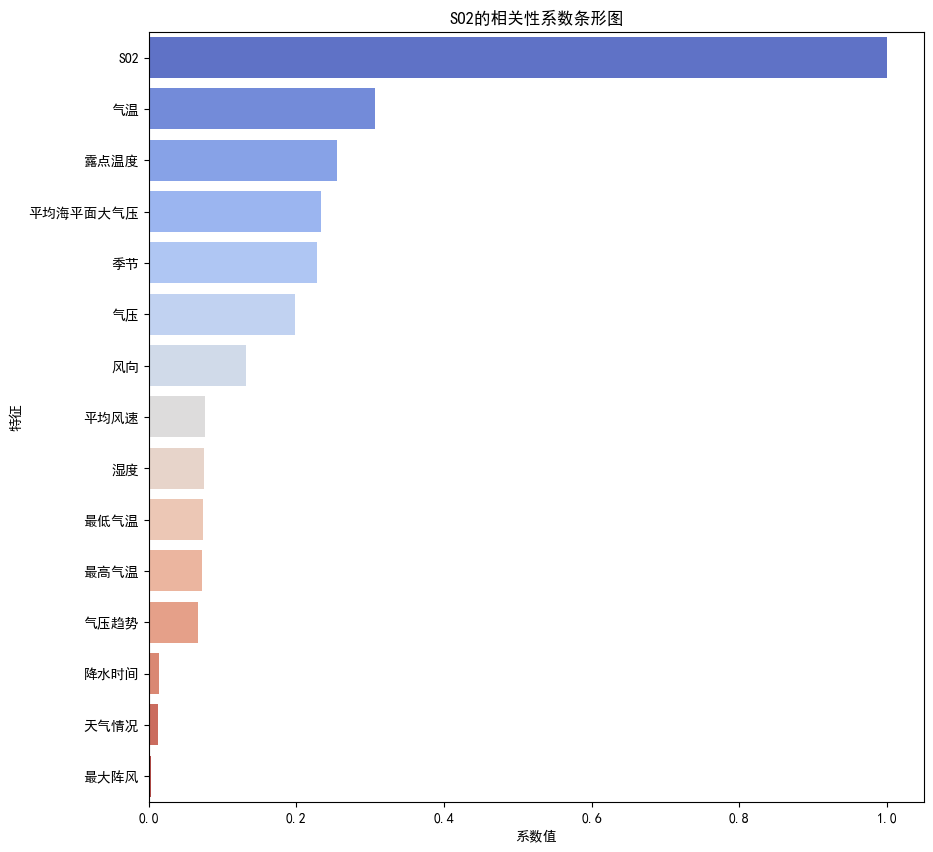


O3_8h的相关性分析结果：

O3_8h       1.000000
气温          0.740916
平均海平面大气压    0.685108
气压          0.682996
露点温度        0.616646
最高气温        0.500138
最低气温        0.460674
降水时间        0.140947
湿度          0.113398
季节          0.060095
平均风速        0.059269
气压趋势        0.026291
天气情况        0.007104
最大阵风        0.004723
风向          0.001603
Name: O3_8h, dtype: float64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22176\1151200639.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlation_abs.values, y=target_correlation_abs.index, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))


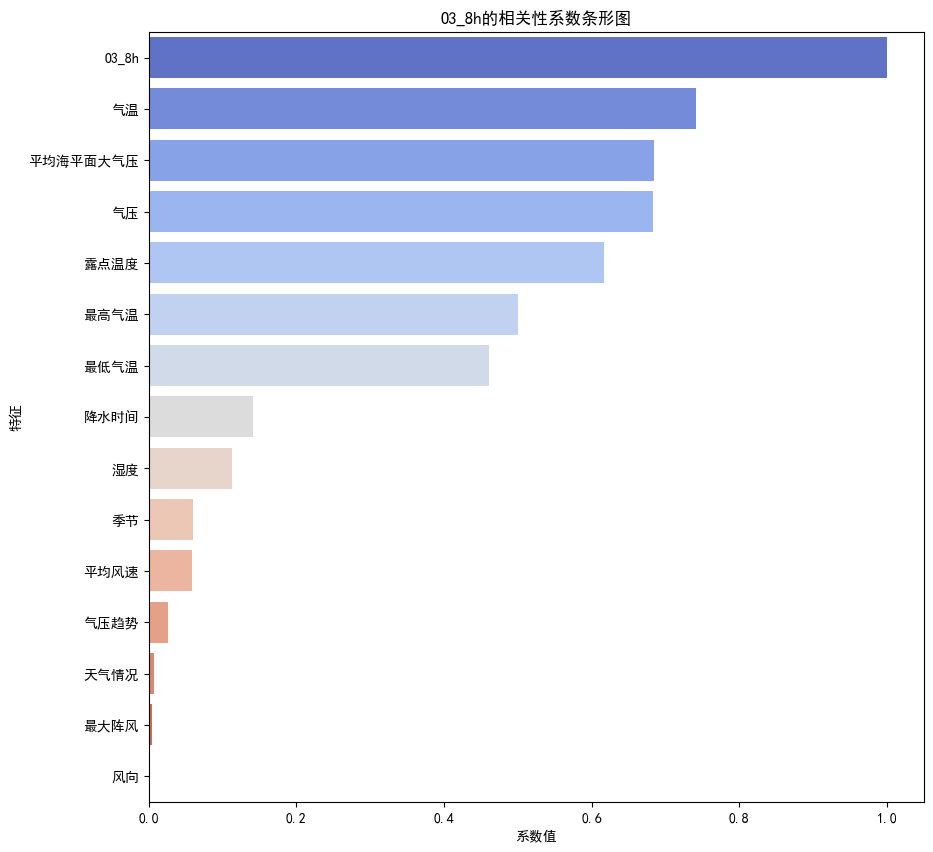

In [6]:
# 定义你需要的列
columns = ['气温', '气压', '平均海平面大气压', '气压趋势', '湿度', '风向', '平均风速', '最大阵风', '天气情况', '最低气温', '最高气温', '露点温度', '降水时间', '季节', 'PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h']

# 初始化编码器
encoder = LabelEncoder()

# 对"季节"进行标签编码
merged_data['季节'] = encoder.fit_transform(merged_data['季节'])

# 目标列列表
targets = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h']

# 对每个目标列进行相关性分析
for target in targets:

    # 暂时移除其他目标列
    temp_columns = [c for c in columns if c not in targets or c == target]

    # 选择这些列进行相关性分析
    selected_data = merged_data[temp_columns]
    correlation = selected_data.corr()

    # 找到与目标列相关的列并按相关性的绝对值进行降序排列
    target_correlation_abs = correlation[target].abs().sort_values(ascending=False)

    # 打印结果
    print(f'\n{target}的相关性分析结果：\n')
    print(target_correlation_abs)

    # 创建一个新的图像并设置其大小
    plt.figure(figsize=(10,10))

    # 创建颜色映射，使用颜色渐变。取决对系数值的绝对值创建颜色映射，以表示相关性强度
    color_map = colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

    # 创建条形图，并用颜色映射来设置每个条的颜色
    sns.barplot(x=target_correlation_abs.values, y=target_correlation_abs.index, palette=sns.color_palette("coolwarm", len(target_correlation_abs)))

    # 添加标题和标签
    plt.title(f'{target}的相关性系数条形图')
    plt.xlabel('系数值')
    plt.ylabel('特征')

    # 显示图像
    plt.show()

筛选出合适的特征进行 回归预测

In [18]:
# 定义每个目标的特征
feature_dict = {
    'PM2.5': ['平均风速', '湿度', '风向', '气温', '气压趋势', '最大阵风', '平均海平面大气压', '最低气温','PM2.5'],
    'PM10': ['平均风速', '气压趋势', '气温', '风向', '最低气温'],
    'NO2': ['气温', '平均风速', '平均海平面大气压', '气压', '最低气温', '露点温度', '最高气温', '气压趋势', '风向', '最大阵风', '降水时间','PM10'],
    'CO': ['平均风速', '气温', '湿度', '风向', '平均海平面大气压', '季节', '气压', '最大阵风', '气压趋势','CO'],
    'SO2': ['气温', '露点温度', '平均海平面大气压', '季节', '气压', '风向','SO2'],
    'O3_8h': ['气温', '平均海平面大气压', '气压', '露点温度', '最高气温', '最低气温', '降水时间', '湿度','O3_8h']
}
# 创建一个空的DataFrame来存储预测结果
result = pd.DataFrame()




# 在每个目标上
for target in feature_dict:
  
    # 设定数据集
    X = merged_data[feature_dict[target]]
    y = merged_data[target]

    # 切分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 特征缩放（对于SVR，这一步非常重要）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 创建SVR模型，你也可以更改内核函数例如使用'poly'或者'sigmoid'
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

    # 训练模型
    model.fit(X_train_scaled, y_train)

    # 对测试集进行预测
    predictions = model.predict(X_test_scaled)

    # 计算MSE
    mse = mean_squared_error(y_test, predictions)

    # 打印MSE的值
    print(f'{target}的 Mean Squared Error:', mse)
    
    # 将预测结果加入到总的结果中
    result[f"Predicted {target}"] = predictions
    result[f"Actual {target}"] = y_test.values
    

# 打印所有预测值和实际值
result.head(20)

PM2.5的 Mean Squared Error: 645.6640196630362
PM10的 Mean Squared Error: 2733.5883683273946
NO2的 Mean Squared Error: 144.949104703928
CO的 Mean Squared Error: 0.038400425436887285
SO2的 Mean Squared Error: 31.604987155637602
O3_8h的 Mean Squared Error: 124.59340398244373


,Predicted PM2.5,Actual PM2.5,Predicted PM10,Actual PM10,Predicted NO2,Actual NO2,Predicted CO,Actual CO,Predicted SO2,Actual SO2,Predicted O3_8h,Actual O3_8h
0,136.204708,252,99.238236,284,84.370285,104,3.509186,3.6,17.942564,18,20.538190,17
1,24.138365,16,45.862187,26,14.847015,12,0.558785,0.6,3.047075,3,81.353162,71
2,23.779034,22,39.611637,40,13.203669,18,0.576160,0.6,2.061661,2,154.787793,159
3,22.209446,14,64.626582,18,21.516255,17,0.514261,0.5,3.046056,3,62.275692,55
4,42.300012,43,72.107803,47,25.482705,28,0.518999,0.6,2.057245,2,59.315973,59
5,84.550307,109,66.076487,76,37.584055,30,1.341557,1.4,6.919507,7,59.430684,66
6,17.232072,10,43.898624,26,18.062922,16,0.391220,0.4,2.357530,2,113.254984,111
7,55.938362,60,71.385442,88,35.605282,39,0.670406,0.7,7.013440,7,154.703421,157
8,109.026258,141,55.332168,77,37.416517,46,1.666535,1.7,16.563972,16,128.550789,130
9,115.942164,188,49.870597,263,63.854739,37,1.000082,1.0,44.917389,53,74.938373,74


In [8]:
# 定义每个目标的特征
feature_dict = {
    'PM2.5': ['平均风速', '湿度', '风向', '气温', '气压趋势', '最大阵风', '平均海平面大气压', '最低气温'],
    'PM10': ['平均风速', '气压趋势', '气温', '风向', '最低气温'],
    'NO2': ['气温', '平均风速', '平均海平面大气压', '气压', '最低气温', '露点温度', '最高气温', '气压趋势', '风向', '最大阵风', '降水时间'],
    'CO': ['平均风速', '气温', '湿度', '风向', '平均海平面大气压', '季节', '气压', '最大阵风', '气压趋势'],
    'SO2': ['气温', '露点温度', '平均海平面大气压', '季节', '气压', '风向'],
    'O3_8h': ['气温', '平均海平面大气压', '气压', '露点温度', '最高气温', '最低气温', '降水时间', '湿度']
}
# 创建一个空的DataFrame来存储预测结果
result = pd.DataFrame()

xgb_parameters = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.75, 1],
    'gamma': [0, 1, 5]
}

# 在每个目标上
for target in feature_dict:
  
    # 设定数据集
    X = merged_data[feature_dict[target]]
    y = merged_data[target]

    # 切分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 选择模型
    if target == 'PM2.5':
        # 为PM2.5使用网格搜索找到最优的XGBoost参数
        model = XGBRegressor(tree_method='hist', device='cuda') # 在此处进行设定
        grid_search = GridSearchCV(model, xgb_parameters, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train)
        model = grid_search.best_estimator_    
    elif target == 'CO':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        model = LinearRegression()

    # 训练模型
    model.fit(X_train_scaled, y_train)

    # 对测试集进行预测
    predictions = model.predict(X_test_scaled)

    # 计算MSE
    mse = mean_squared_error(y_test, predictions)


    # 打印MSE的值
    print(f'{target}的 Mean Squared Error:', mse)
    
    # 将预测结果加入到总的结果中
    result[f"Predicted {target}"] = predictions
    result[f"Actual {target}"] = y_test.values
    

# 打印所有预测值和实际值
print(result.head(20))

d:\Software\Python\Lib\site-packages\xgboost\core.py:160: UserWarning: [08:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

时间序列预测

In [9]:
# 定义每个目标的特征
feature_dict = {
    'PM2.5': ['平均风速', '湿度', '风向', '气温', '气压趋势', '最大阵风', '平均海平面大气压', '最低气温'],
    'PM10': ['平均风速', '气压趋势', '气温', '风向', '最低气温'],
    'NO2': ['气温', '平均风速', '平均海平面大气压', '气压', '最低气温', '露点温度', '最高气温', '气压趋势', '风向', '最大阵风', '降水时间'],
    'CO': ['平均风速', '气温', '湿度', '风向', '平均海平面大气压', '季节', '气压', '最大阵风', '气压趋势'],
    'SO2': ['气温', '露点温度', '平均海平面大气压', '季节', '气压', '风向'],
    'O3_8h': ['气温', '平均海平面大气压', '气压', '露点温度', '最高气温', '最低气温', '降水时间', '湿度']
}
# 定义用于预测的时间步数
forecast_steps = 5

# 创建一个空的DataFrame用于存储预测结果
all_forecasts = pd.DataFrame()

# 标准化器
scaler = MinMaxScaler(feature_range=(0, 1))

for target, features in feature_dict.items():
    # 进行目标变量的预测
    data = merged_data[target]
    data = scaler.fit_transform(data.values.reshape(-1, 1))
    model = ARIMA(data, order=(5, 1, 0))   # order 的参数由 AIC 或 BIC 准则确定
    model_fit = model.fit()
    target_forecast = model_fit.forecast(steps=forecast_steps)

    # 将目标变量预测值存到结果DataFrame
    all_forecasts[target] = target_forecast
    
    # 对每个特征进行预测
    for feature in features:
        data = merged_data[feature]
        data = scaler.fit_transform(data.values.reshape(-1, 1))
        model = ARIMA(data, order=(5, 1, 0))   # order 的参数由 AIC 或 BIC 准则确定
        model_fit = model.fit()
        feature_forecast = model_fit.forecast(steps=forecast_steps)
        
        # 将特征的预测值存到结果DataFrame
        all_forecasts[feature] = feature_forecast

    # 查看预测结果 DataFrame
    print(all_forecasts.head())
    # 创建一个空的DataFrame用于存储预测结果
    prediction_result = pd.DataFrame()

    # 训练模型
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(merged_data[feature_dict[target]], merged_data[target])

    # 预测未来N个时间点
    future_forecast = model.predict(all_forecasts[feature_dict[target]])

    # 将预测结果加入到总的结果DataFrame
    prediction_result['Predicted_' + target] = future_forecast

    # 打印预测值
    print(f'Predicted future {target}:', future_forecast)

    # 打印预测结果 DataFrame
    print(prediction_result.head())

KeyboardInterrupt: 

时间序列预测模型

In [ ]:
# 特征和目标变量选择
feature_cols = ['气温', '平均海平面大气压', '气压', '露点温度', '最高气温', '最低气温', '降水时间', '湿度','O3_8h'] 
target_cols = ['O3_8h']

X = merged_data[feature_cols].values
y = merged_data[target_cols].values

# 数据规范化
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

def create_dataset(X, y, window_size):
    data_seq = []
    label_seq = []
    length = len(X)
    for i in range(length - window_size):
        window_data = X[i : i + window_size, :]
        window_label = y[i + window_size]
        data_seq.append(window_data)
        label_seq.append(window_label)
    return np.array(data_seq), np.array(label_seq)

window_size = 7  
X_dataset, y_dataset = create_dataset(X, y, window_size)

# 划分训练集和测试集
train_size = int(len(X_dataset) * 0.8)
test_size = len(X_dataset) - train_size


# 获取训练集和测试集的X，y
X_train, y_train = X_dataset[:train_size], y_dataset[:train_size]
X_test, y_test = X_dataset[train_size:], y_dataset[train_size:]

# 设置模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.Tensor(x)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).detach()
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).detach()
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])  
        return out

model = LSTMModel(X_train.shape[2], 128, 1, 2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 进行训练
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, torch.Tensor(y_train))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch} \tLoss: {loss.item()}')
        
# 评估模型
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
train_loss = criterion(y_train_pred, torch.Tensor(y_train)).item() 
test_loss = criterion(y_test_pred, torch.Tensor(y_test)).item()

# 训练集和测试集上的损失
print("Train loss: %.3f" % train_loss)
print("Test loss: %.3f" % test_loss)

# 对预测结果进行反归一化
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# 对真实结果进行反归一化
y_train_real = scaler.inverse_transform(y_train)
y_test_real = scaler.inverse_transform(y_test)

# 为预测结果和真实结果创建DataFrame
train_dict = {}
test_dict = {}
for idx, col in enumerate(target_cols):
    train_dict[col+'_pred'] = y_train_pred[:, idx]
    train_dict[col+'_real'] = y_train_real[:, idx]
    test_dict[col+'_pred'] = y_test_pred[:, idx]
    test_dict[col+'_real'] = y_test_real[:, idx]
train_result = pd.DataFrame(train_dict)
test_result = pd.DataFrame(test_dict)

# 计算RMSE
train_rmse = np.sqrt(train_loss)
test_rmse = np.sqrt(test_loss)

print("Train RMSE: %.3f" % train_rmse)
print("Test RMSE: %.3f" % test_rmse)

# 训练集的R2 score
r2_train = r2_score(y_train_real, y_train_pred)
print("Train R^2: %.3f" % r2_train)

# 测试集的R2 score
r2_test = r2_score(y_test_real, y_test_pred)
print("Test R^2: %.3f" % r2_test)

test_result

Epoch: 0 	Loss: 0.11275748908519745
Epoch: 10 	Loss: 0.032901208847761154
Epoch: 20 	Loss: 0.02033434435725212
Epoch: 30 	Loss: 0.01662355847656727
Epoch: 40 	Loss: 0.01426304504275322
Epoch: 50 	Loss: 0.013597064651548862
Epoch: 60 	Loss: 0.012909411452710629
Epoch: 70 	Loss: 0.012348520569503307
Epoch: 80 	Loss: 0.011907948181033134
Epoch: 90 	Loss: 0.011476278305053711
Train loss: 0.011
Test loss: 0.010
Train RMSE: 0.105
Test RMSE: 0.098
Train R^2: 0.702
Test R^2: 0.680


,O3_8h_pred,O3_8h_real
0,37.037033,32.0
1,40.720921,22.0
2,41.972225,65.0
3,50.578987,67.0
4,55.863922,30.0
...,...,...
730,19.057470,0.0
731,21.677528,34.0
732,27.526384,21.0
733,24.517090,45.0


In [ ]:
# 特征和目标变量选择
feature_cols = ['气温', '平均海平面大气压', '气压', '露点温度', '最高气温', '最低气温', '降水时间', '湿度','O3_8h'] 
target_cols = ['O3_8h']

X = merged_data[feature_cols].values
y = merged_data[target_cols].values

# 数据规范化
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

def create_dataset(X, y, window_size):
    data_seq = []
    label_seq = []
    length = len(X)
    for i in range(length - window_size):
        window_data = X[i : i + window_size, :]
        window_label = y[i + window_size]
        data_seq.append(window_data)
        label_seq.append(window_label)
    return np.array(data_seq), np.array(label_seq)

window_size = 7  
X_dataset, y_dataset = create_dataset(X, y, window_size)

# 划分训练集和测试集
train_size = int(len(X_dataset) * 0.8)
test_size = len(X_dataset) - train_size


# 获取训练集和测试集的X，y
X_train, y_train = X_dataset[:train_size], y_dataset[:train_size]
X_test, y_test = X_dataset[train_size:], y_dataset[train_size:]

# 设置模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.Tensor(x)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).detach()
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).detach()
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])  
        return out

model = LSTMModel(X_train.shape[2], 128, 1, 2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 进行训练
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, torch.Tensor(y_train))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch} \tLoss: {loss.item()}')
        
# 评估模型
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
train_loss = criterion(y_train_pred, torch.Tensor(y_train)).item() 
test_loss = criterion(y_test_pred, torch.Tensor(y_test)).item()

# 训练集和测试集上的损失
print("Train loss: %.3f" % train_loss)
print("Test loss: %.3f" % test_loss)

# 对预测结果进行反归一化
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# 对真实结果进行反归一化
y_train_real = scaler.inverse_transform(y_train)
y_test_real = scaler.inverse_transform(y_test)

# 为预测结果和真实结果创建DataFrame
train_dict = {}
test_dict = {}
for idx, col in enumerate(target_cols):
    train_dict[col+'_pred'] = y_train_pred[:, idx]
    train_dict[col+'_real'] = y_train_real[:, idx]
    test_dict[col+'_pred'] = y_test_pred[:, idx]
    test_dict[col+'_real'] = y_test_real[:, idx]
train_result = pd.DataFrame(train_dict)
test_result = pd.DataFrame(test_dict)

# 计算RMSE
train_rmse = np.sqrt(train_loss)
test_rmse = np.sqrt(test_loss)

print("Train RMSE: %.3f" % train_rmse)
print("Test RMSE: %.3f" % test_rmse)

# 训练集的R2 score
r2_train = r2_score(y_train_real, y_train_pred)
print("Train R^2: %.3f" % r2_train)

# 测试集的R2 score
r2_test = r2_score(y_test_real, y_test_pred)
print("Test R^2: %.3f" % r2_test)

test_result

Epoch: 0 	Loss: 0.10242171585559845
Epoch: 10 	Loss: 0.031894534826278687
Epoch: 20 	Loss: 0.018624432384967804
Epoch: 30 	Loss: 0.017154980450868607
Epoch: 40 	Loss: 0.014707257971167564
Epoch: 50 	Loss: 0.013401344418525696
Epoch: 60 	Loss: 0.01241430826485157
Epoch: 70 	Loss: 0.011808994226157665
Epoch: 80 	Loss: 0.01127883605659008
Epoch: 90 	Loss: 0.011018553748726845
Train loss: 0.011
Test loss: 0.009
Train RMSE: 0.104
Test RMSE: 0.096
Train R^2: 0.708
Test R^2: 0.689


,O3_8h_pred,O3_8h_real
0,41.350193,32.0
1,43.997211,22.0
2,42.813171,65.0
3,50.989227,67.0
4,55.922283,30.0
...,...,...
730,19.375181,0.0
731,21.112106,34.0
732,26.289581,21.0
733,23.028431,45.0


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.Tensor(x).to(device)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).detach().to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).detach().to(device)
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])  
        return out

def create_dataset(X, y, window_size):
    data_seq = []
    label_seq = []
    length = len(X)
    for i in range(length - window_size):
        window_data = X[i : i + window_size, :]
        window_label = y[i + window_size]
        data_seq.append(window_data)
        label_seq.append(window_label)
    return np.array(data_seq), np.array(label_seq)

def process_data(df, feature_cols, target_cols, window_size=7):

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = df[feature_cols].values
    y = df[target_cols].values

    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)

    # Create the dataset
    X_dataset, y_dataset = create_dataset(X, y, window_size)

    # Split the dataset into training and testing sets
    train_size = int(len(X_dataset) * 0.8)
    test_size = len(X_dataset) - train_size

    X_train, y_train = X_dataset[:train_size], y_dataset[:train_size]
    X_test, y_test = X_dataset[train_size:], y_dataset[train_size:]

    return X_train, y_train, X_test, y_test, scaler

def train_model(X_train, y_train, X_test, y_test, scaler, feature_cols, target_cols, epochs=100):

    model = LSTMModel(X_train.shape[2], 128, 1, 2).to(device)  # move model to device
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Move data to device
    X_train = torch.Tensor(X_train).to(device)
    y_train = torch.Tensor(y_train).to(device)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0: 
            print(f'Epoch: {epoch} \tLoss: {loss.item()}')
        
    # Evaluate the model
    with torch.no_grad():
        # Move data to device
        X_test = torch.Tensor(X_test).to(device)
        y_test = torch.Tensor(y_test).to(device)
        
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        
    train_loss = criterion(y_train_pred, y_train).item() 
    test_loss = criterion(y_test_pred, y_test).item()

    y_train_pred = y_train_pred.detach().cpu().numpy()   # 将预测结果移动到CPU
    y_test_pred = y_test_pred.detach().cpu().numpy()     # 将预测结果移动到CPU
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)

    y_train_real = y_train.cpu().numpy()    # 将真实值移动到CPU
    y_test_real = y_test.cpu().numpy()      # 将真实值移动到CPU
    y_train_real = scaler.inverse_transform(y_train_real)
    y_test_real = scaler.inverse_transform(y_test_real)

    train_dict = {}
    test_dict = {}
    for idx, col in enumerate(target_cols):
        train_dict[col+'_pred'] = y_train_pred[:, idx]
        train_dict[col+'_real'] = y_train_real[:, idx]
        test_dict[col+'_pred'] = y_test_pred[:, idx]
        test_dict[col+'_real'] = y_test_real[:, idx]
    train_result = pd.DataFrame(train_dict)
    test_result = pd.DataFrame(test_dict)


    # 计算RMSE
    train_rmse = np.sqrt(train_loss)
    test_rmse = np.sqrt(test_loss)

    print("Train RMSE: %.3f" % train_rmse)
    print("Test RMSE: %.3f" % test_rmse)

    # 训练集的R2 score
    r2_train = r2_score(y_train_real, y_train_pred)
    print("Train R^2: %.3f" % r2_train)

    # 测试集的R2 score
    r2_test = r2_score(y_test_real, y_test_pred)
    print("Test R^2: %.3f" % r2_test)

    return train_result, test_result

feature_dict = {
    'PM2.5': ['平均风速', '湿度', '风向', '气温', '气压趋势', '最大阵风', '平均海平面大气压', '最低气温','PM2.5'],
    'PM10': ['平均风速', '气压趋势', '气温', '风向', '最低气温','PM10'],
    'NO2': ['气温', '平均风速', '平均海平面大气压', '气压', '最低气温', '露点温度', '最高气温', '气压趋势', '风向', '最大阵风', '降水时间','NO2'],
    'CO': ['平均风速', '气温', '湿度', '风向', '平均海平面大气压', '季节', '气压', '最大阵风', '气压趋势','CO'],
    'SO2': ['气温', '露点温度', '平均海平面大气压', '季节', '气压', '风向','SO2'],
    'O3_8h': ['气温', '平均海平面大气压', '气压', '露点温度', '最高气温', '最低气温', '降水时间', '湿度','O3_8h']
}

# Loop over the dictionary to process data and train a model for each target
for target, features in feature_dict.items():
    # add target to features list
    features.append(target)
    X_train, y_train, X_test, y_test, scaler = process_data(merged_data, features, [target])
    train_result, test_result = train_model(X_train, y_train, X_test, y_test, scaler, features, [target])
    print(test_result)

    


Epoch: 0 	Loss: 0.038332197815179825
Epoch: 10 	Loss: 0.013394604437053204
Epoch: 20 	Loss: 0.012989003211259842
Epoch: 30 	Loss: 0.01104271411895752
Epoch: 40 	Loss: 0.009559047408401966
Epoch: 50 	Loss: 0.008376723155379295
Epoch: 60 	Loss: 0.0076932464726269245
Epoch: 70 	Loss: 0.007406032644212246
Epoch: 80 	Loss: 0.007272147107869387
Epoch: 90 	Loss: 0.007204096298664808
Train RMSE: 0.084
Test RMSE: 0.050
Train R^2: 0.474
Test R^2: 0.323
     PM2.5_pred  PM2.5_real
0     29.939812        23.0
1     53.429356        35.0
2     51.339649        11.0
3     18.069838        11.0
4     22.001661        21.0
..          ...         ...
730   33.081287        26.0
731   35.878094        45.0
732   46.975395        98.0
733   88.688248       115.0
734   86.755402        12.0

[735 rows x 2 columns]
Epoch: 0 	Loss: 0.0276825912296772
Epoch: 10 	Loss: 0.008819203823804855
Epoch: 20 	Loss: 0.008460551500320435
Epoch: 30 	Loss: 0.007980696856975555
Epoch: 40 	Loss: 0.007210148964077234
Epoch:

In [11]:


# 特征和目标变量选择
feature_cols = ['气温', '平均风速', '平均海平面大气压', '气压', '最低气温', '露点温度', '最高气温', '气压趋势', '风向', '最大阵风', '降水时间','PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h'] 
target_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3_8h']

X = merged_data[feature_cols].values
y = merged_data[target_cols].values

# 数据规范化
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转换输入形状为(samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.Tensor(x)
        output, (hn, cn) = self.lstm(x)
        hn = hn.view(-1, self.hidden_dim)
        out = self.fc(hn)
        return out
    
model = LSTMModel(X_train.shape[2], 128, len(target_cols))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8) # 加入了权重衰减项

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model.forward(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, torch.Tensor(y_train))
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:  # print loss every 1 epochs
        print(f'Epoch: {epoch} \tLoss: {loss.item()}')

with torch.no_grad():
    y_train_pred = model.forward(X_train)
    y_test_pred = model.forward(X_test)
train_loss = criterion(y_train_pred, torch.Tensor(y_train)).item() 
test_loss = criterion(y_test_pred, torch.Tensor(y_test)).item()

# 训练集和测试集上的损失
print("Train loss: %.3f" % train_loss)
print("Test loss: %.3f" % test_loss)


# 获取预测结果，并进行反归一化
y_train_pred = model(X_train).detach().numpy()
y_test_pred = model(X_test).detach().numpy()
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# 对真实结果进行反归一化
y_train_real = scaler.inverse_transform(y_train)
y_test_real = scaler.inverse_transform(y_test)

# 为预测结果和真实结果创建DataFrame
train_dict = {}
test_dict = {}
for idx, col in enumerate(target_cols):
    train_dict[col+'_pred'] = y_train_pred[:, idx]
    train_dict[col+'_real'] = y_train_real[:, idx]
    test_dict[col+'_pred'] = y_test_pred[:, idx]
    test_dict[col+'_real'] = y_test_real[:, idx]
train_result = pd.DataFrame(train_dict)
test_result = pd.DataFrame(test_dict)

# 计算RMSE
train_rmse = np.sqrt(train_loss)
test_rmse = np.sqrt(test_loss)

print("Train RMSE: %.3f" % train_rmse)
print("Test RMSE: %.3f" % test_rmse)

# 训练集的R2 score
r2_train = r2_score(y_train_real, y_train_pred)
print("Train R^2: %.3f" % r2_train)

# 测试集的R2 score
r2_test = r2_score(y_test_real, y_test_pred)
print("Test R^2: %.3f" % r2_test)

# 显示结果
test_result.to_csv('测试集结果.csv')

recent_data = X[-1:, :] 
predictions = []

for _ in range(300): # 对未来300天进行预测
    recent_data = recent_data.reshape((1, *recent_data.shape)) # 改变数据形状以匹配模型输入
    pred = model(recent_data).detach().numpy()
    predictions.append(pred)
    # 使用预测值创建新的输入数据
    next_input = np.concatenate((recent_data.reshape(-1)[len(target_cols):], pred), axis=None)
    recent_data = next_input

predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[2]) # 改变数据形状以匹配模型输入
predictions = scaler.inverse_transform(predictions) # 将预测数据进行反归一化
predictions_df = pd.DataFrame(predictions, columns=target_cols)
predictions_df.to_csv('pred.csv')

Epoch: 0 	Loss: 0.042480383068323135
Epoch: 1 	Loss: 0.021265478804707527
Epoch: 2 	Loss: 0.014904214069247246
Epoch: 3 	Loss: 0.018077246844768524
Epoch: 4 	Loss: 0.017358742654323578
Epoch: 5 	Loss: 0.013818809762597084
Epoch: 6 	Loss: 0.011710159480571747
Epoch: 7 	Loss: 0.011738265864551067
Epoch: 8 	Loss: 0.012186129577457905
Epoch: 9 	Loss: 0.011386876925826073
Epoch: 10 	Loss: 0.009364156052470207
Epoch: 11 	Loss: 0.0075406767427921295
Epoch: 12 	Loss: 0.006920245010405779
Epoch: 13 	Loss: 0.006944223307073116
Epoch: 14 	Loss: 0.006724396254867315
Epoch: 15 	Loss: 0.006187254097312689
Epoch: 16 	Loss: 0.005476147402077913
Epoch: 17 	Loss: 0.004901761654764414
Epoch: 18 	Loss: 0.004731078632175922
Epoch: 19 	Loss: 0.004727597814053297
Epoch: 20 	Loss: 0.004656194243580103
Epoch: 21 	Loss: 0.004456078168004751
Epoch: 22 	Loss: 0.004093891475349665
Epoch: 23 	Loss: 0.0037602498196065426
Epoch: 24 	Loss: 0.0036472950596362352
Epoch: 25 	Loss: 0.0036651059053838253
Epoch: 26 	Loss: 0